# 🚀 Reto de Ingeniería de Datos: Optimización y Visualización
**Diplomado en Estrategias de Datos - USTA**
* **Estudiante:** Fredy Alejandro Chavarro Sierra
* **Fecha:** 03/01/2025

**Descripción:** En este cuaderno aplico técnicas de *downcasting*, vectorización y visualización avanzada sobre el dataset de Taxis de NYC (1.4M registros).


**Celda 2 (Código) - Configuración Inicial:**

In [ ]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from fpdf import FPDF

# Configuración para que los gráficos se vean bien en retina display
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid")

# Ocultar advertencias molestas (opcional)
import warnings
warnings.filterwarnings('ignore')


**Celda 3 (Markdown/Código) - Carga y Diagnóstico**

In [2]:
df = pd.read_csv("data/train.csv")
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 417.3 MB


**Celda 4 (Markdown/Código) - Fase 1: Optimización (Pandas Pro):**

In [3]:
#Númericas
df["passenger_count"] = pd.to_numeric(df["passenger_count"], downcast="integer")
df["trip_duration"] = pd.to_numeric(df["trip_duration"], downcast="integer")
df["vendor_id"] = pd.to_numeric(df["vendor_id"], downcast="integer")

#Categoricas
df["store_and_fwd_flag"] = df["store_and_fwd_flag"].astype("category")

#- Definir las columnas de fecha y hora
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"],format="%Y-%m-%d %H:%M:%S")
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"],format="%Y-%m-%d %H:%M:%S")

df.info(memory_usage='deep')




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int8          
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int8          
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  category      
 10  trip_duration       1458644 non-null  int32         
dtypes: category(1), datetime64[ns](2), float64(4), int32(1), int8(2), object(1)
memory usage: 157.2 MB


**Celda 5 (Markdown/Código) - Fase 2: Ingeniería de Variables:**

In [8]:

# Agregar columna de hora del día

df["hour"] = df["pickup_datetime"].dt.hour
hour_counts = df["hour"].value_counts().sort_index()
hour_counts

# Agregar columna de tipo de viaje basado en duración

df["trip_type"] = np.where( df["trip_duration"] > 3600,"Largo","Corto")

# Cálculo de la distancia Haversine

R = 6371.0

# Convertir grados a radianes (vectorizado)
lat1 = np.radians(df["pickup_latitude"].to_numpy())
lon1 = np.radians(df["pickup_longitude"].to_numpy())
lat2 = np.radians(df["dropoff_latitude"].to_numpy())
lon2 = np.radians(df["dropoff_longitude"].to_numpy())

# Deltas
dlat = lat2 - lat1
dlon = lon2 - lon1

# Fórmula Haversine
a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon / 2.0) ** 2)
c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))

# Distancia en km
df["haversine_km"] = R * c

# Filtrar el DataFrame (Query)

df_filtrado = df.query("passenger_count > 1 and 0 < haversine_km < 100")

# Calcular velocidad y ordenar (assign)

df= (
    df.assign(
        velocidad_kph=lambda x: x["haversine_km"] / (x["trip_duration"] / 3600)
    )
    .sort_values("velocidad_kph", ascending=False)
)

# Calcular Outliers en trip_duration (clip)

df["trip_duration"] = df["trip_duration"].clip(lower=60, upper=7200)
df["trip_duration"].describe()

# Agregar etiqueta de tráfico (pipe)

def etiqueta_trafico(df):
    return df.assign(
        trafico=np.where(
            df["velocidad_kph"] < 20, "Pesado",
            np.where(df["velocidad_kph"] < 40, "Moderado", "Fluido")
        )
    )

df= (
    df.query("passenger_count > 1 and 0 < haversine_km < 100")
      .assign(
          velocidad_kph=lambda x: x["haversine_km"] / (x["trip_duration"] / 3600)
      )
      .pipe(etiqueta_trafico)
)

# Resumen por vendor_id (groupby y agg)

df_vendor = (
    df.groupby("vendor_id", as_index=False)
      .agg(
          mean_duration=("trip_duration", "mean"),
          total_km=("haversine_km", "sum")
      )
)

# Calcular duración promedio por vendor_id (transform)

df["avg_duration_by_vendor"] = (
    df.groupby("vendor_id")["trip_duration"].transform("mean")
)

df[["vendor_id", "trip_duration", "avg_duration_by_vendor"]].head()

# filtrar por hora con más de 16,000 viajes (filter)

df_filtrado_hora = (
    df.groupby("hour")
      .filter(lambda x: len(x) > 16_000)
)
df_filtrado_hora["hour"].value_counts().sort_index()

# Crear bins de distancia (qcut)

df["distancia_bin"] = pd.qcut(
    df["haversine_km"],
    q=4,
    labels=["Muy Corto", "Corto", "Largo", "Muy Largo"]
)
df["distancia_bin"].value_counts()

# Resumen de viajes por día (resample y agg)

viajes_por_dia = (
    df.set_index("pickup_datetime")
      .resample("D")
      .size()
)

summary_viajes_por_dia = viajes_por_dia.agg(
    total_dias="count",
    promedio_diario="mean",
    minimo_diario="min",
    maximo_diario="max"
).to_frame(name="valor")


**Celda 6 (Markdown/Código) - Fase 3: Visualización Avanzada:**

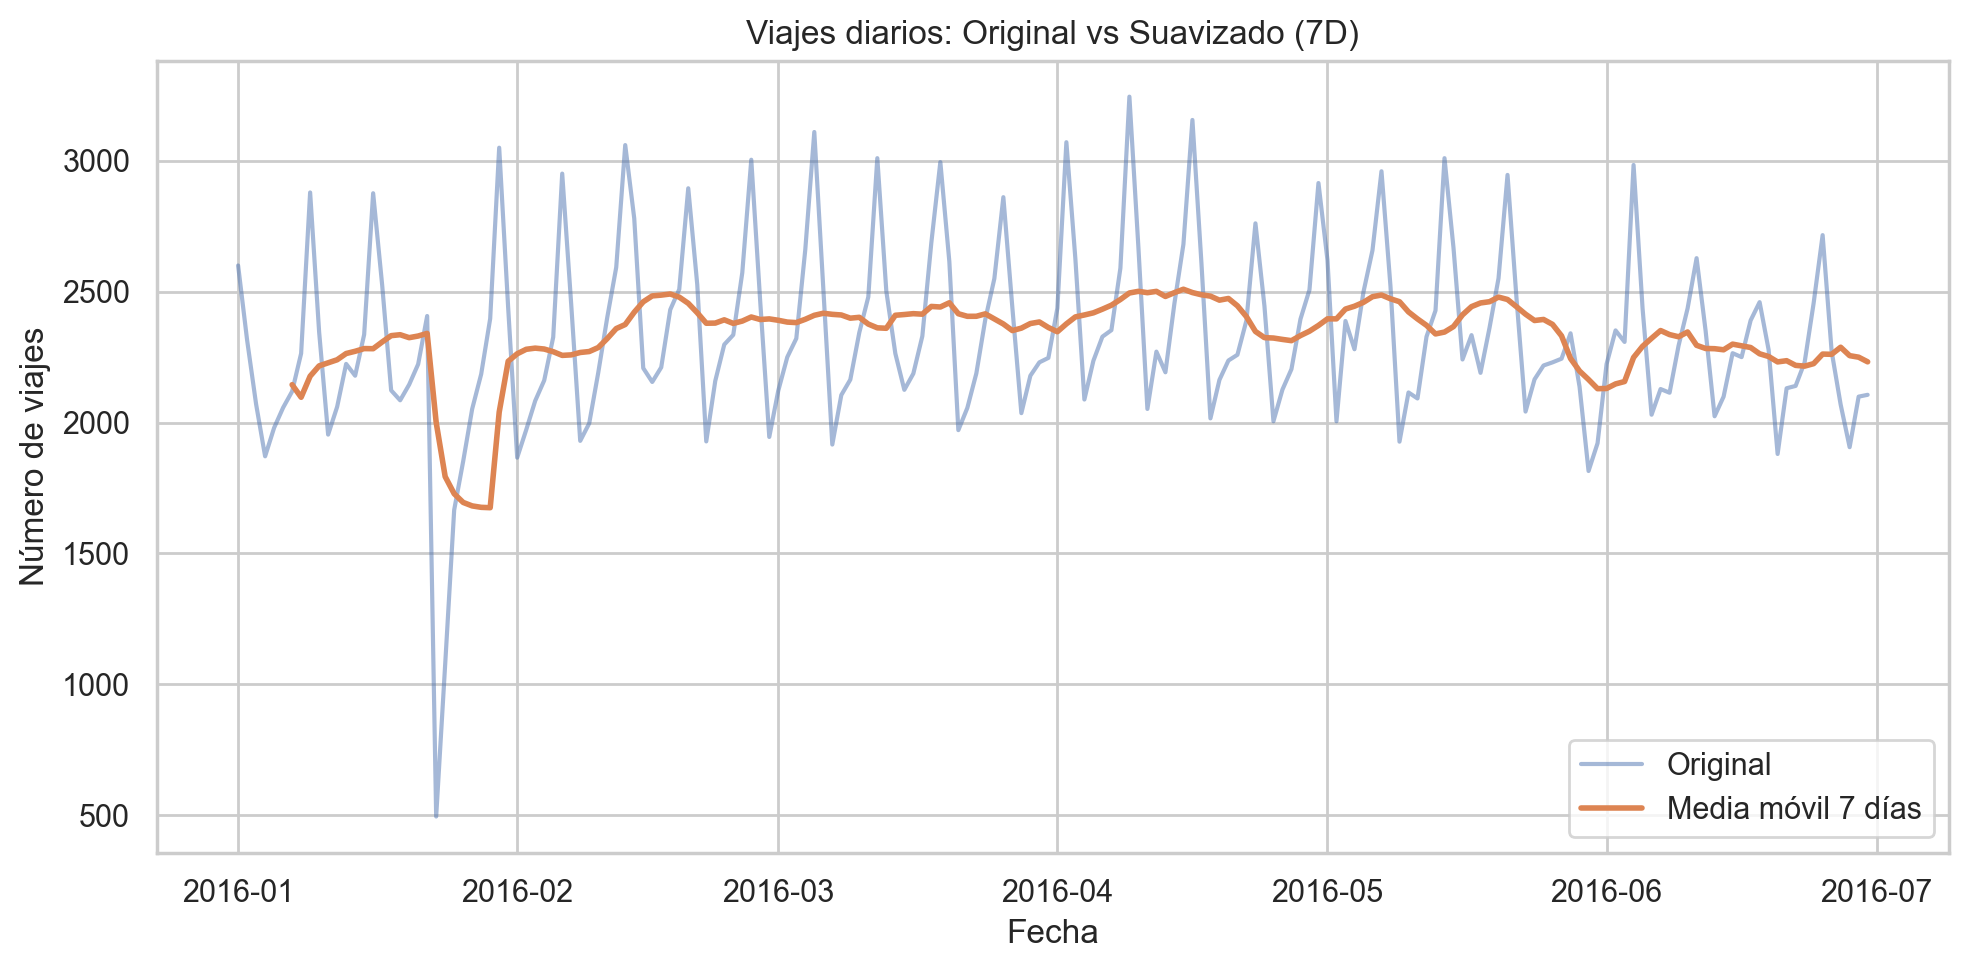

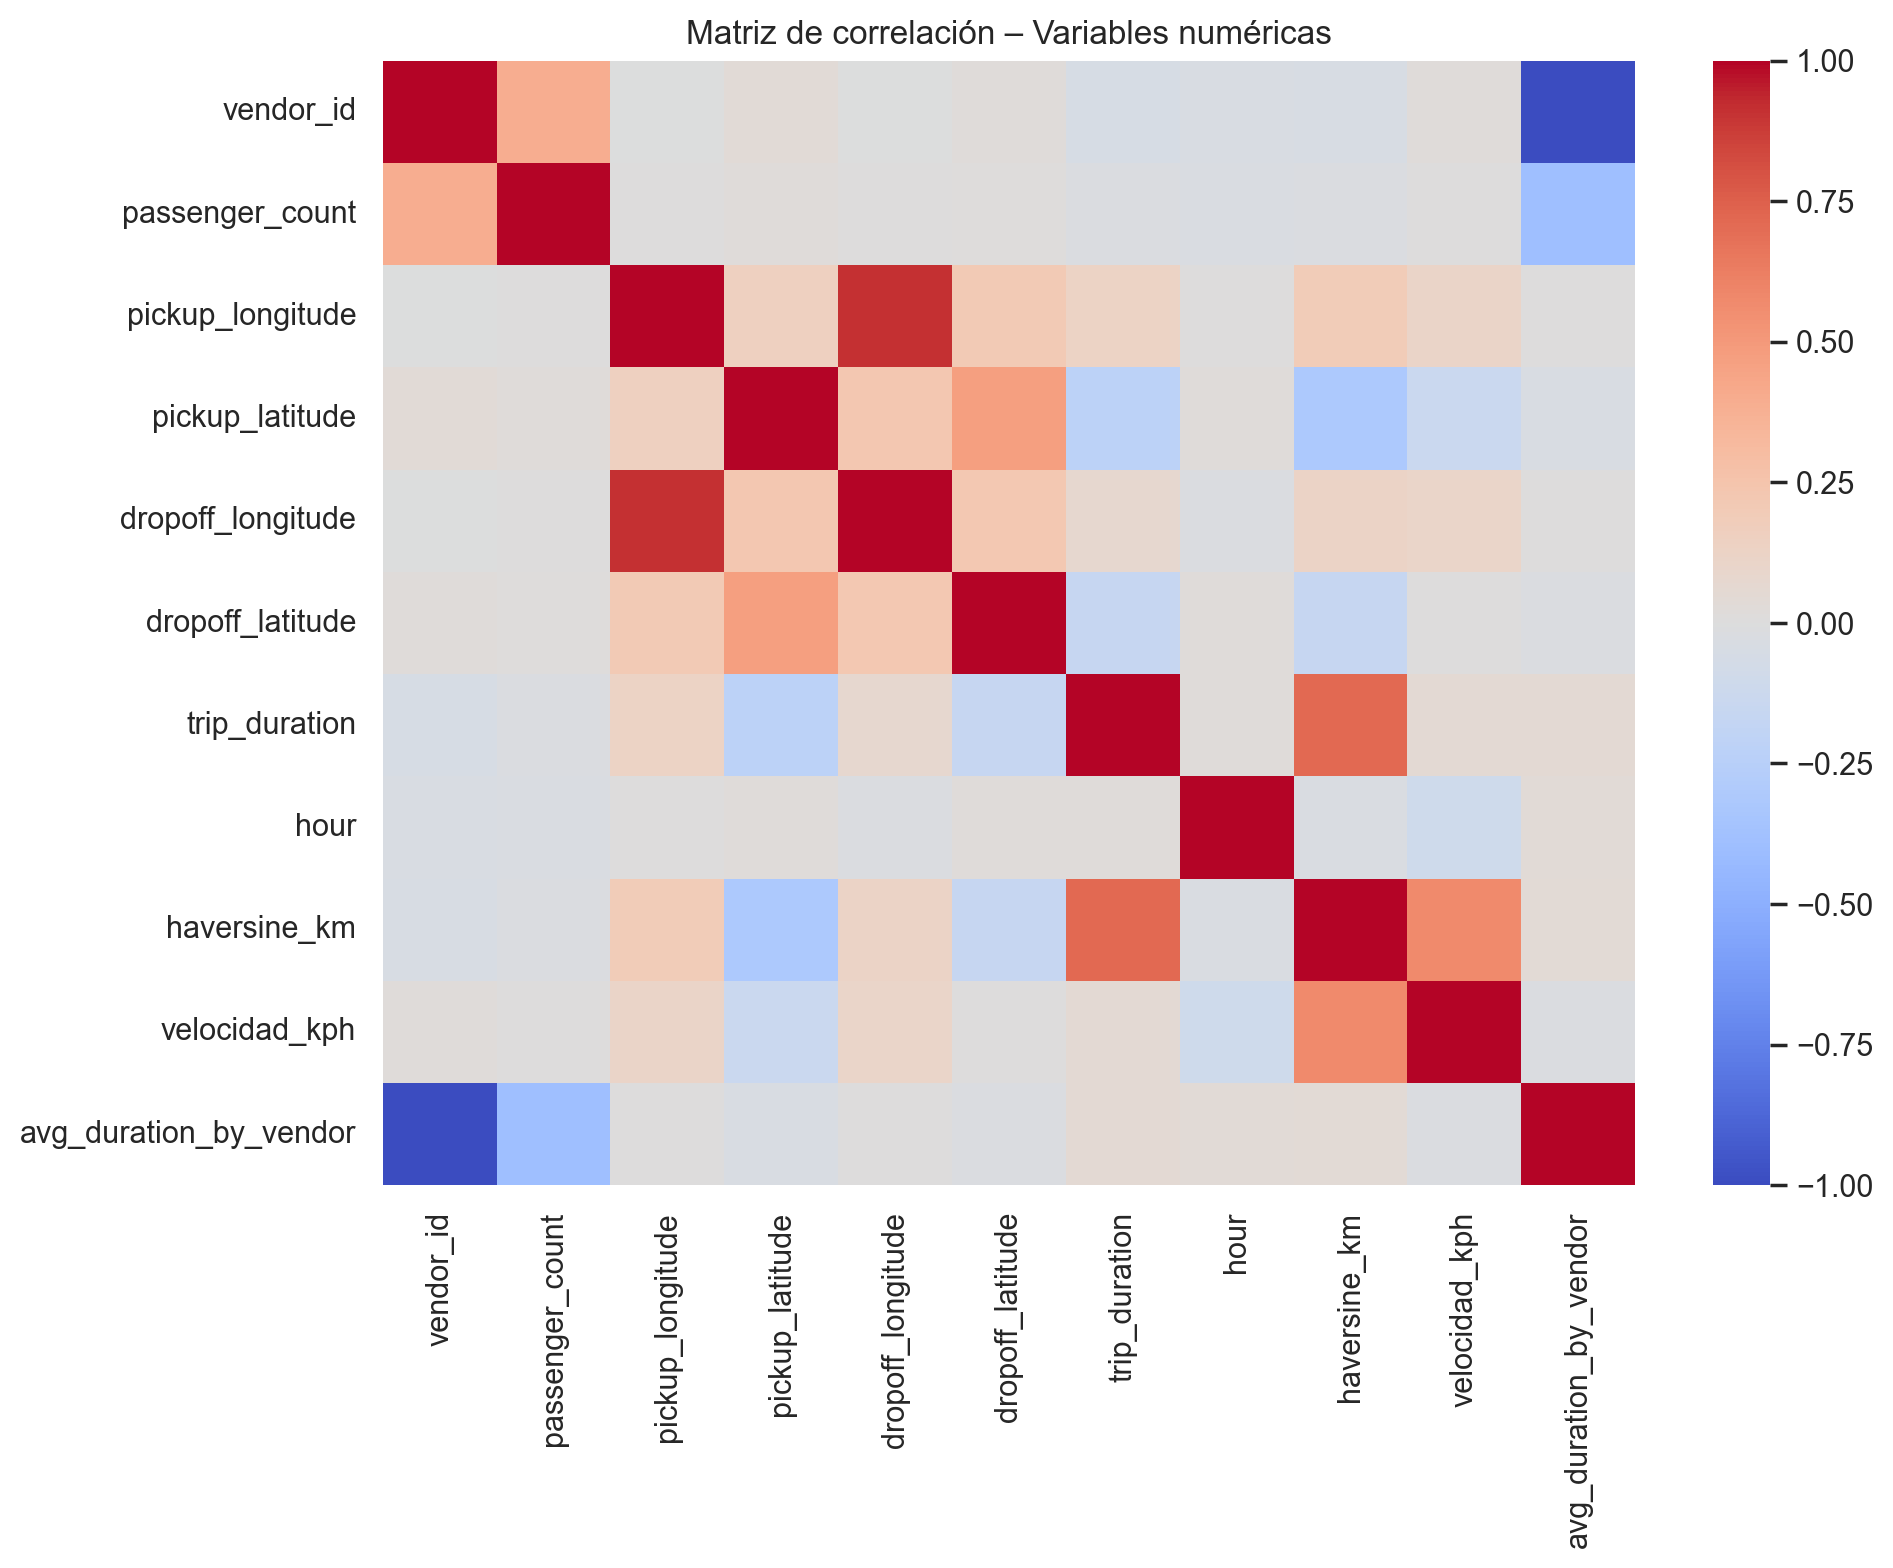

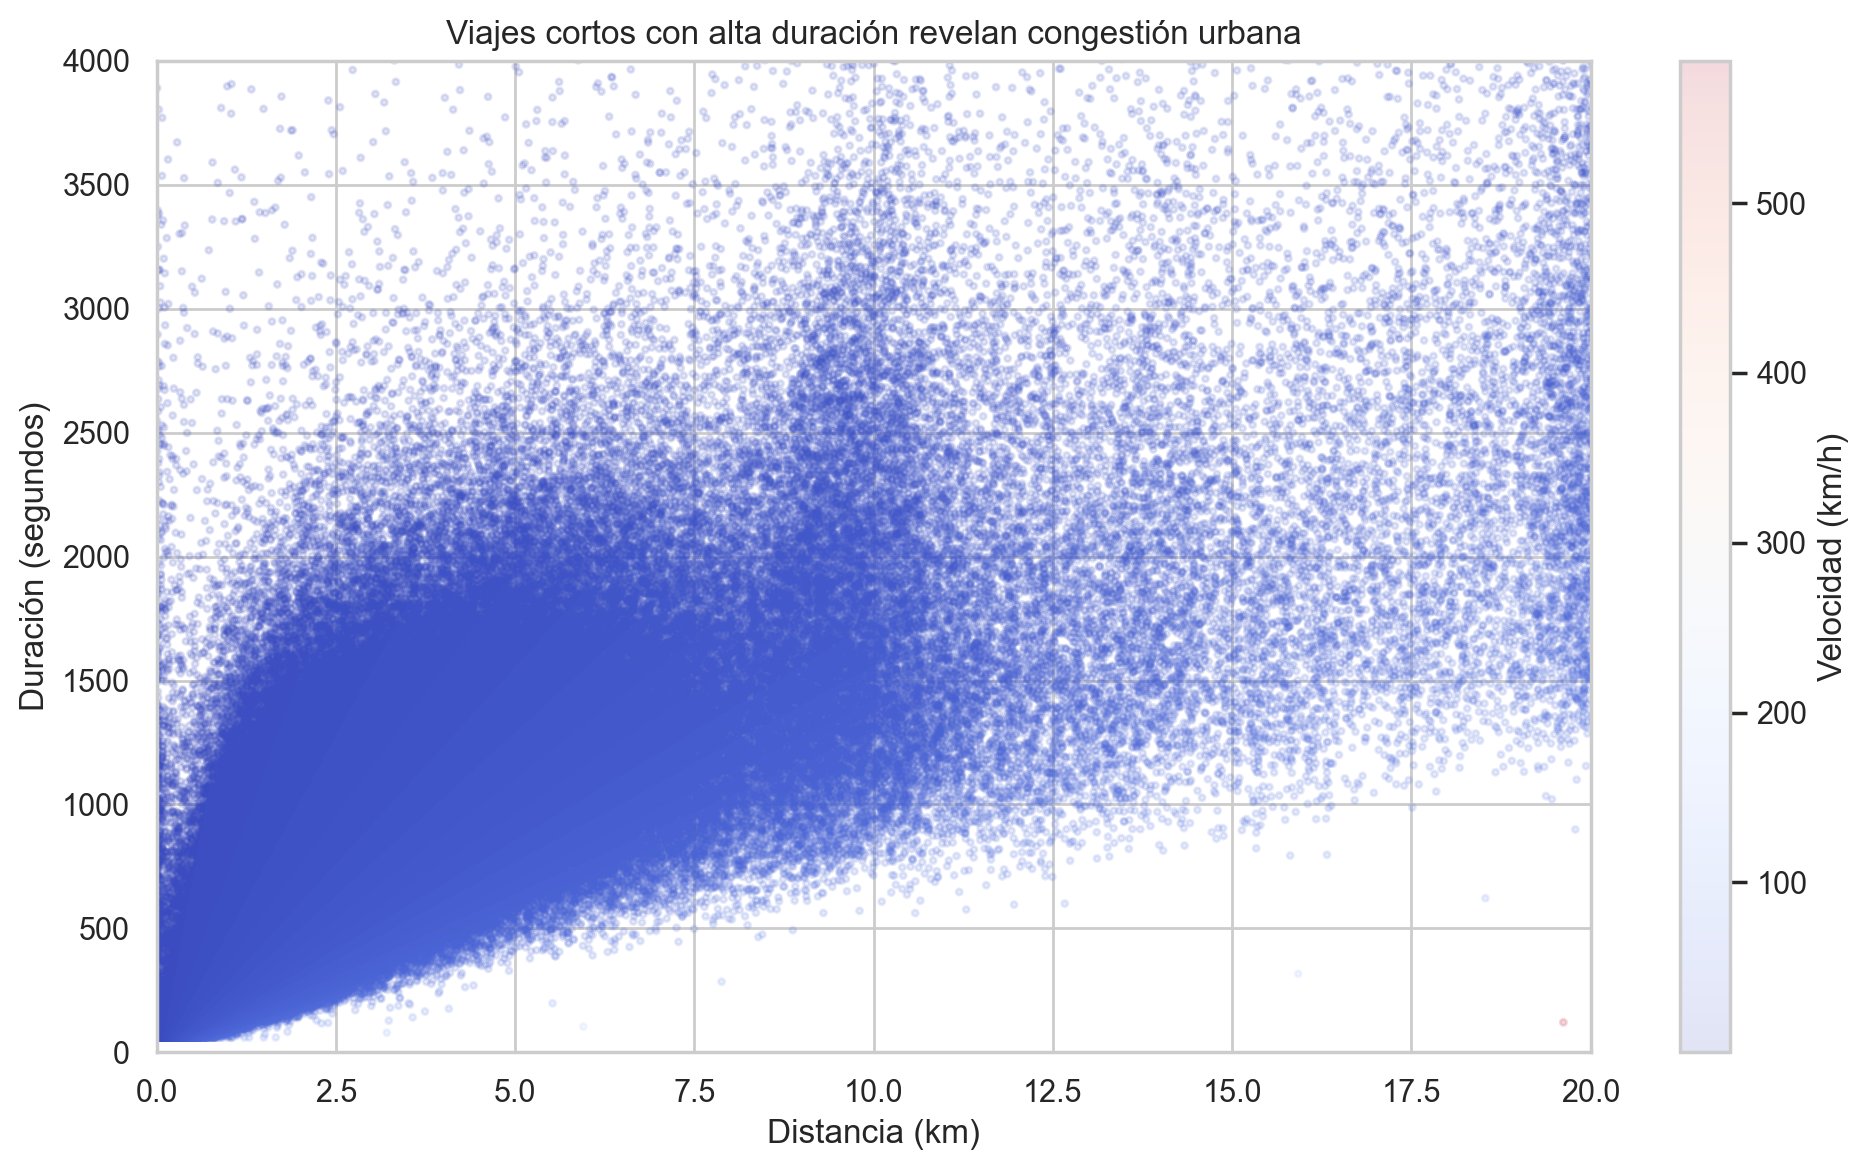

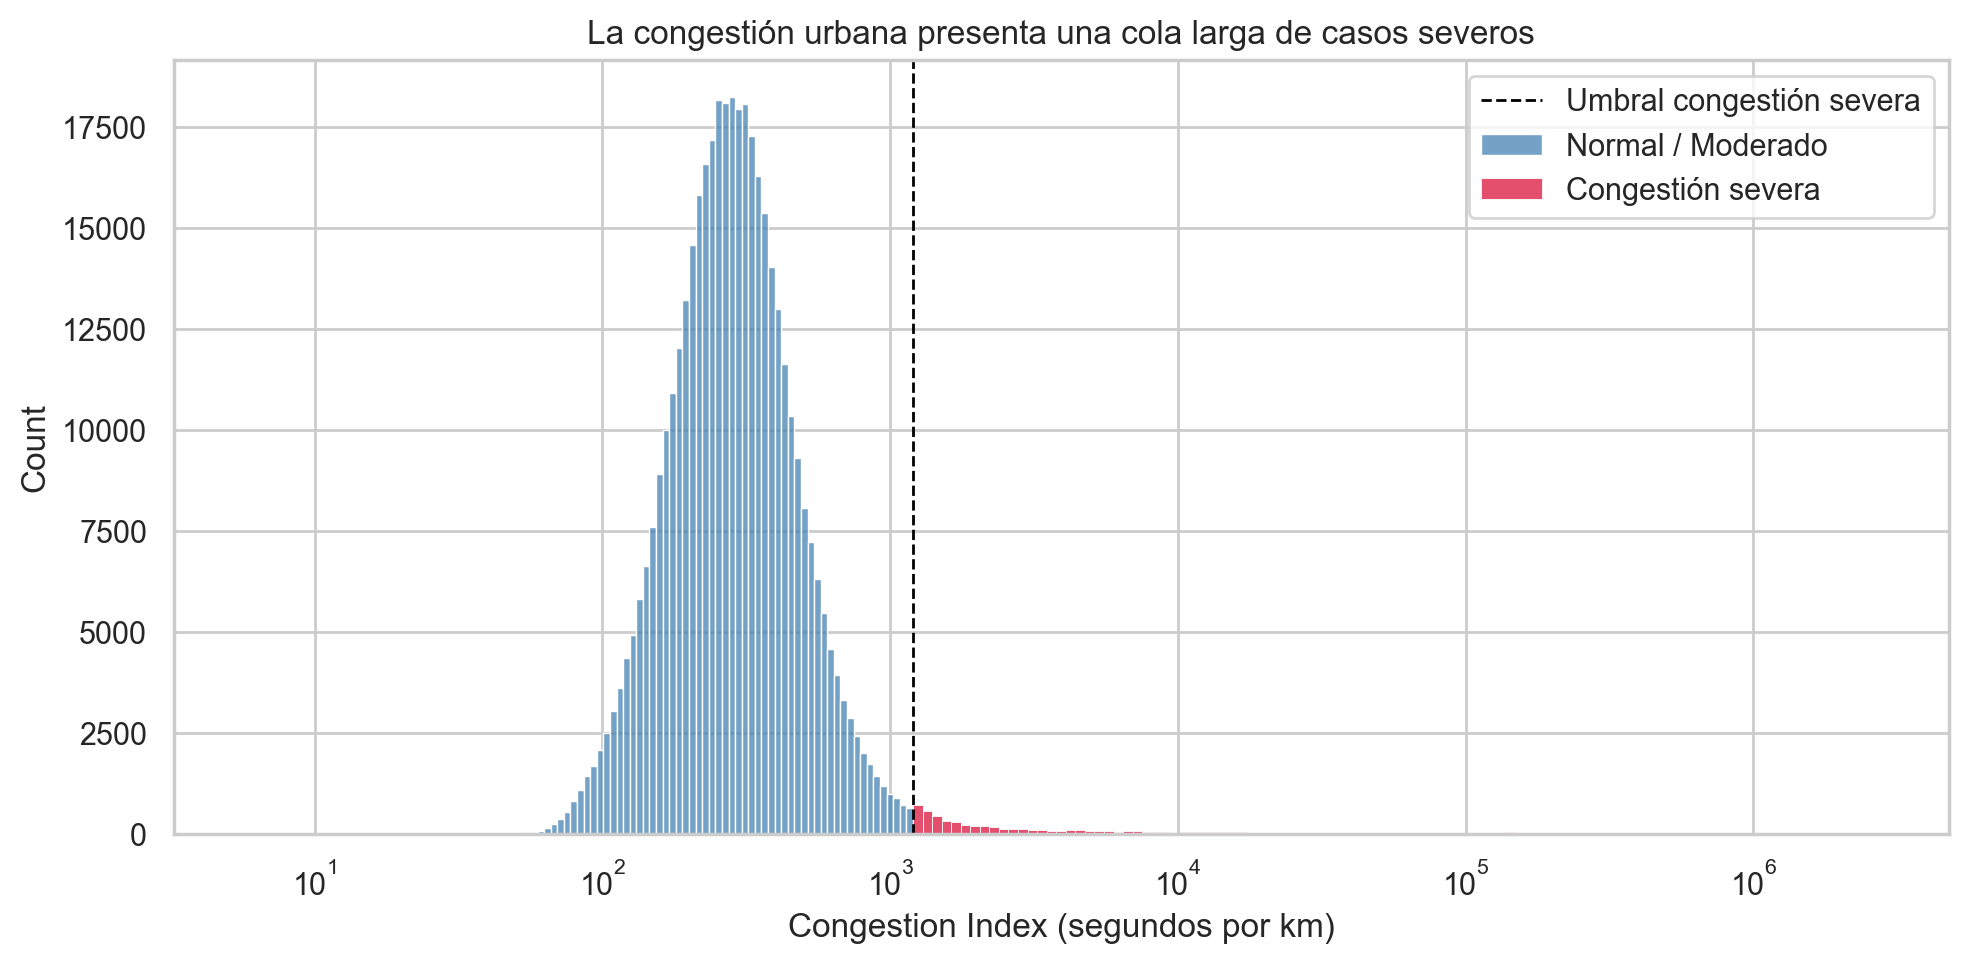

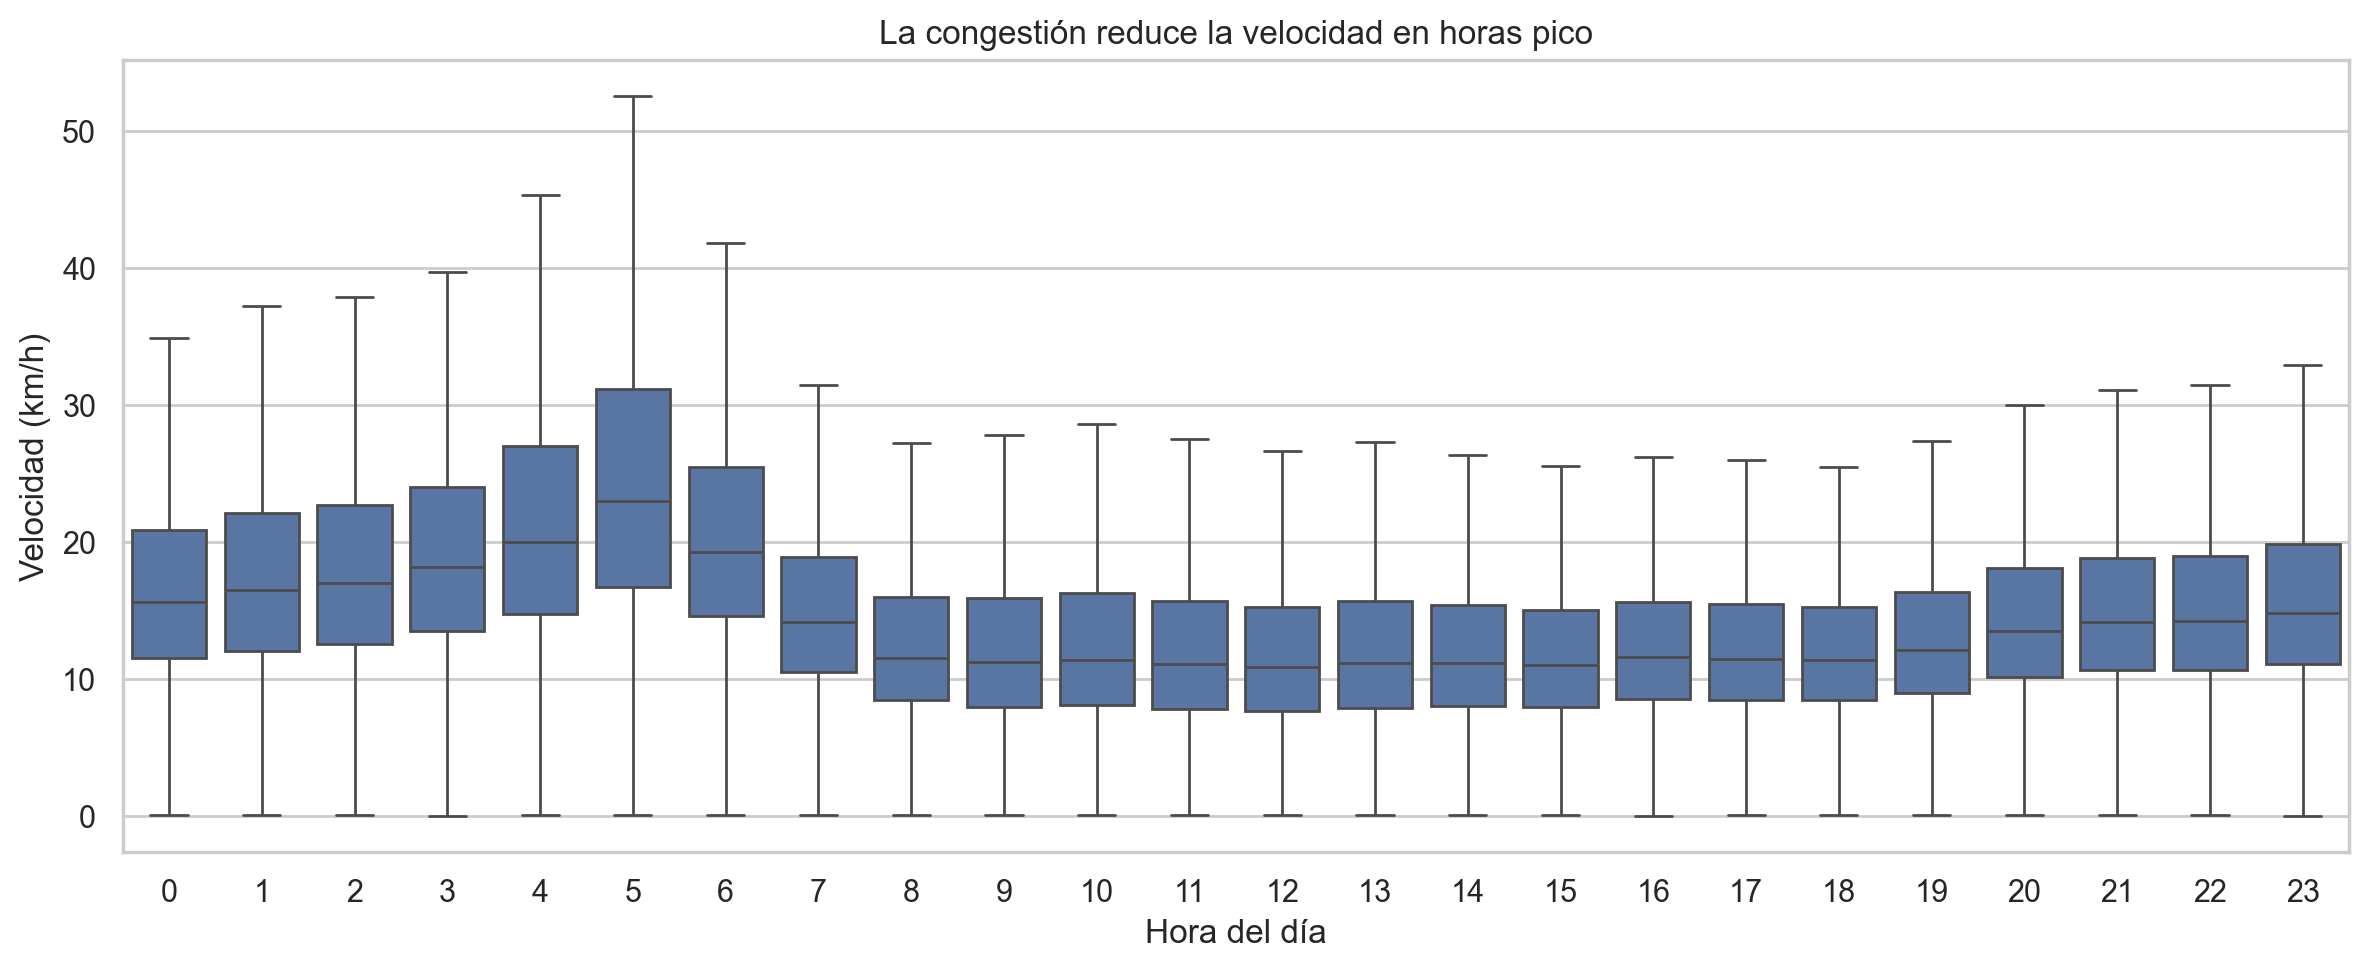

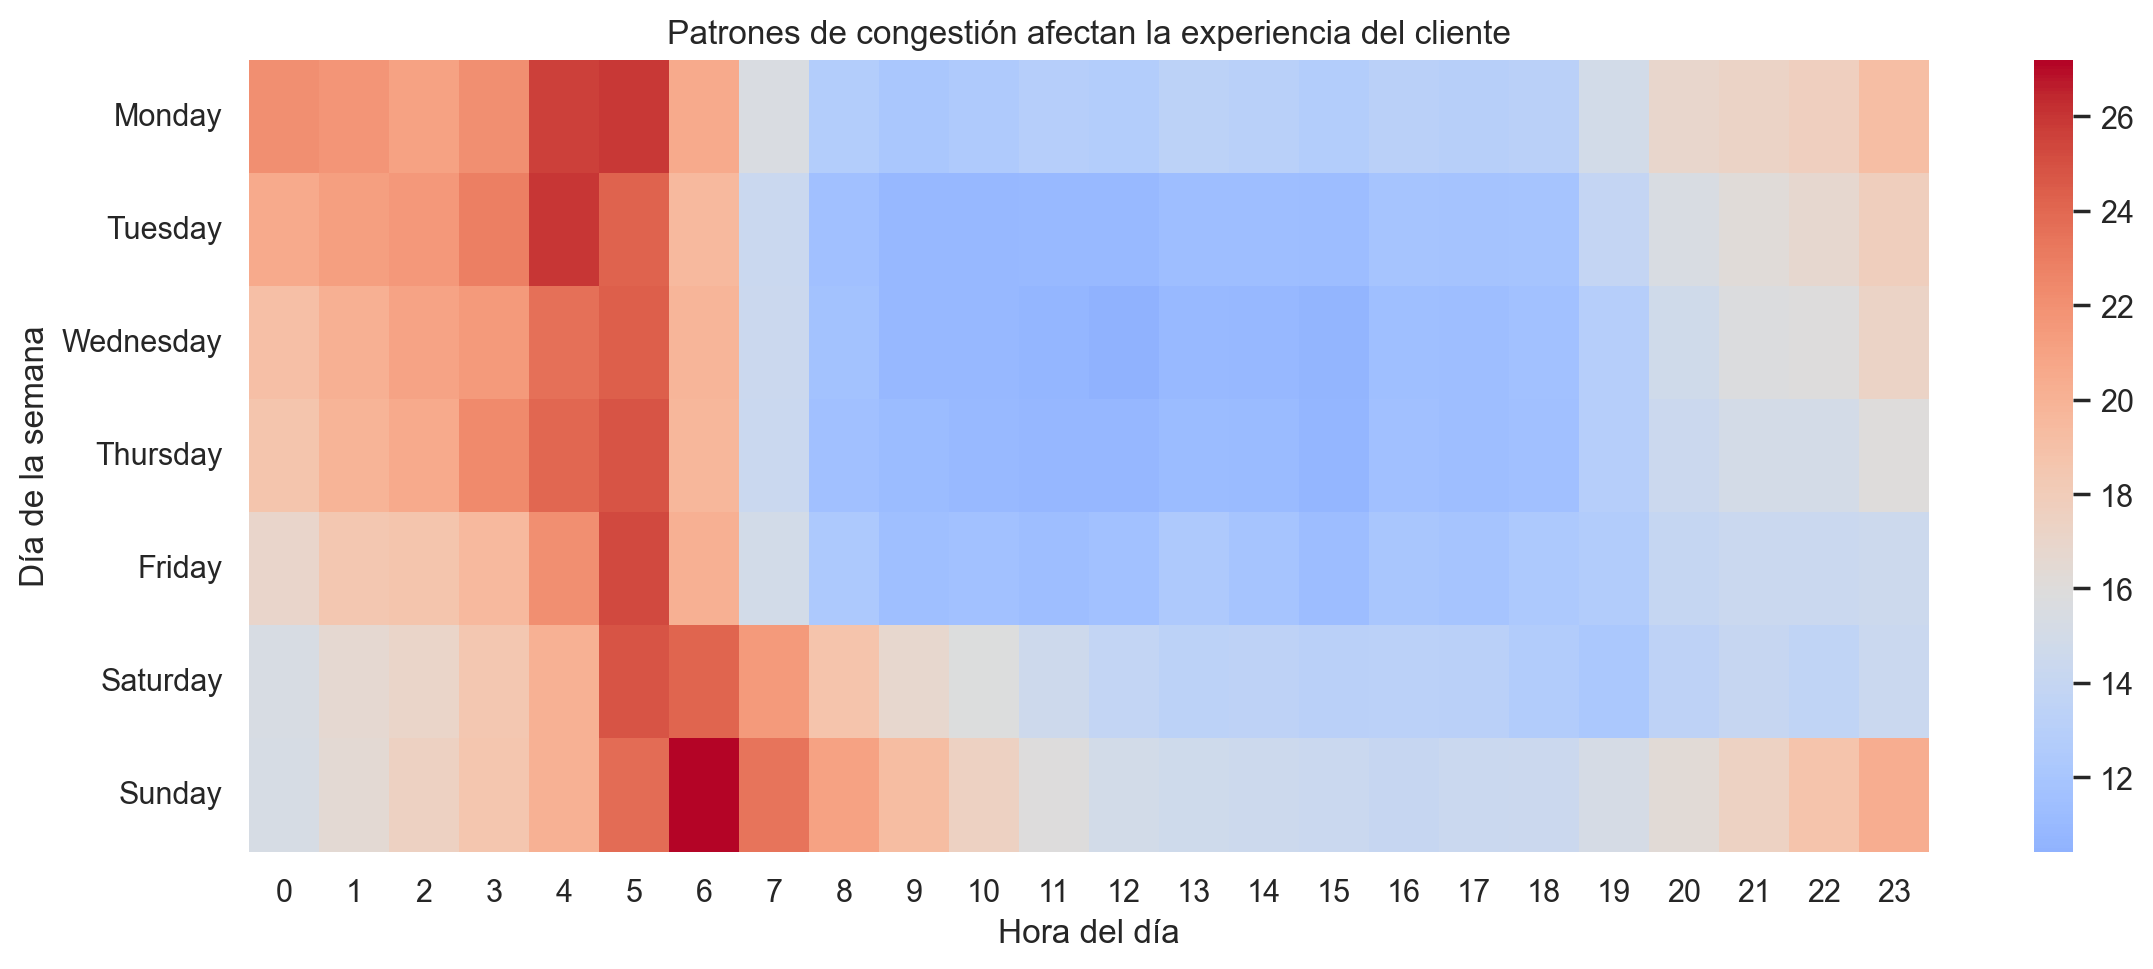

,hour,lat_bin,lon_bin,viajes_criticos,congestion_promedio,total_viajes,ratio_critico
1,17,40.76,-73.98,60,1968.071222,1307,0.045907
3,13,40.76,-73.98,52,2253.861994,1241,0.041902
4,15,40.76,-73.98,48,2140.978181,1205,0.039834
0,18,40.76,-73.98,64,2431.696809,1680,0.038095
2,19,40.76,-73.98,57,2079.268177,1701,0.033510


In [6]:
#viajes diarios suavizados con media móvil de 7 días (rolling y mean)

viajes_suavizado_7d = viajes_por_dia.rolling(7).mean()

plt.figure(figsize=(10, 5))
plt.plot(viajes_por_dia, label="Original", alpha=0.5)
plt.plot(viajes_suavizado_7d, label="Media móvil 7 días", linewidth=2)

plt.title("Viajes diarios: Original vs Suavizado (7D)")
plt.xlabel("Fecha")
plt.ylabel("Número de viajes")
plt.legend()
plt.tight_layout()
plt.show()


# Mapa de calor de correlación (heatmap)

corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False
)

plt.title("Matriz de correlación – Variables numéricas")
plt.tight_layout()
plt.show()

# Gráfico de dispersión con color por velocidad

plt.figure(figsize=(10, 6))
plt.scatter(
    df["haversine_km"],
    df["trip_duration"],
    c=df["velocidad_kph"],
    cmap="coolwarm",
    alpha=0.15,
    s=5
)

plt.colorbar(label="Velocidad (km/h)")
plt.xlabel("Distancia (km)")
plt.ylabel("Duración (segundos)")
plt.title("Viajes cortos con alta duración revelan congestión urbana")

plt.xlim(0, 20)
plt.ylim(0, 4000)

plt.tight_layout()
plt.savefig("figures/scatter_dist_dur.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Histograma de índice de congestión

df["congestion_index"] = np.where(
    df["haversine_km"] > 0,
    df["trip_duration"] / df["haversine_km"],
    np.nan
)
# Umbral de congestión severa
THRESHOLD = 1200

# Separar datos
normal = df.loc[df["congestion_index"] <= THRESHOLD, "congestion_index"]
problematicos = df.loc[df["congestion_index"] > THRESHOLD, "congestion_index"]

plt.figure(figsize=(10, 5))

# Histograma principal (normal)
sns.histplot(
    normal,
    bins=100,
    log_scale=True,
    color="steelblue",
    label="Normal / Moderado"
)

# Histograma de casos problemáticos
sns.histplot(
    problematicos,
    bins=100,
    log_scale=True,
    color="crimson",
    label="Congestión severa"
)

plt.axvline(
    THRESHOLD,
    color="black",
    linestyle="--",
    linewidth=1,
    label="Umbral congestión severa"
)

plt.xlabel("Congestion Index (segundos por km)")
plt.ylabel("Count")
plt.title("La congestión urbana presenta una cola larga de casos severos")
plt.legend()

plt.tight_layout()
plt.savefig("figures/congestion_hist.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

#boxplot de velocidad por hora del día

plt.figure(figsize=(12, 5))
sns.boxplot(
    data=df,
    x="hour",
    y="velocidad_kph",
    showfliers=False
)

plt.xlabel("Hora del día")
plt.ylabel("Velocidad (km/h)")
plt.title("La congestión reduce la velocidad en horas pico")

plt.tight_layout()
plt.savefig("figures/boxplot.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

#heatmap dia-hora de congestion

df["day_name"] = df["pickup_datetime"].dt.day_name()

pivot_vel = (
    df.pivot_table(
        index="day_name",
        columns="hour",
        values="velocidad_kph",
        aggfunc="mean"
    )
)

order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot_vel = pivot_vel.reindex(order_days)

plt.figure(figsize=(12, 5))
sns.heatmap(
    pivot_vel,
    cmap="coolwarm",
    center=pivot_vel.values.mean()
)

plt.xlabel("Hora del día")
plt.ylabel("Día de la semana")
plt.title("Patrones de congestión afectan la experiencia del cliente")

plt.tight_layout()
plt.savefig("figures/heatmap.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Análisis de zonas y horas con más congestión severa

THRESHOLD = 1200
df_criticos = df[df["congestion_index"] > THRESHOLD].copy()

df_criticos["lat_bin"] = df_criticos["pickup_latitude"].round(2)
df_criticos["lon_bin"] = df_criticos["pickup_longitude"].round(2)

top5_hora_zona = (
    df_criticos
        .groupby(["hour", "lat_bin", "lon_bin"])
        .size()
        .sort_values(ascending=False)
        .head(5)
        .reset_index(name="viajes_criticos")
)

top5_hora_zona

severidad = (
    df_criticos
        .groupby(["hour", "lat_bin", "lon_bin"])["congestion_index"]
        .mean()
        .reset_index(name="congestion_promedio")
)

top5_hora_zona = top5_hora_zona.merge(
    severidad,
    on=["hour", "lat_bin", "lon_bin"],
    how="left"
)

top5_hora_zona

total_hora_zona = (
    df
      .assign(
          lat_bin=df["pickup_latitude"].round(2),
          lon_bin=df["pickup_longitude"].round(2)
      )
      .groupby(["hour", "lat_bin", "lon_bin"])
      .size()
      .reset_index(name="total_viajes")
)

top5_hora_zona = top5_hora_zona.merge(
    total_hora_zona,
    on=["hour", "lat_bin", "lon_bin"],
    how="left"
)

top5_hora_zona["ratio_critico"] = (
    top5_hora_zona["viajes_criticos"] / top5_hora_zona["total_viajes"]
)

top5_hora_zona.sort_values("ratio_critico", ascending=False)


**Celda 7 (Markdown/Código) - Fase 4: Reporte Automatizado (PDF) y exportar base (.Parquet):**

In [7]:
df.to_parquet("df.parquet")

size_parquet_mb = os.path.getsize("df.parquet") / (1024**2)
size_parquet_mb

#=====================================================

from fpdf import FPDF

# ======================================================
# 1) UTILIDAD: convertir texto a latin-1 seguro para FPDF
# ======================================================
def pdf_safe(text: str) -> str:
    replacements = {
        "“": '"', "”": '"',
        "‘": "'", "’": "'",
        "–": "-", "—": "-",
        "•": "-", "…": "...",
        " ": " "  # espacio no separable
    }
    for bad, good in replacements.items():
        text = text.replace(bad, good)

    return text.encode("latin-1", "ignore").decode("latin-1")


# ======================================================
# 2) HELPERS DE ESCRITURA
# ======================================================
def add_title(pdf, text):
    pdf.set_font("Arial", "B", 16)
    pdf.multi_cell(0, 10, pdf_safe(text), align="C")
    pdf.ln(2)

def add_subtitle(pdf, text):
    pdf.set_font("Arial", "", 11)
    pdf.multi_cell(0, 7, pdf_safe(text))
    pdf.ln(3)

def add_paragraph(pdf, text, line_height=6):
    pdf.set_font("Arial", "", 11)
    for p in text.strip().split("\n"):
        p = p.strip()
        if p:
            pdf.multi_cell(0, line_height, pdf_safe(p))
            pdf.ln(1)

def add_caption(pdf, text):
    pdf.set_font("Arial", "I", 10)
    pdf.multi_cell(0, 6, pdf_safe(text))
    pdf.ln(2)

def add_image_inline(pdf, image_path, width=190):
    pdf.image(image_path, x=10, w=width)
    pdf.ln(5)


# ======================================================
# 3) METRICAS DINAMICAS 
# ======================================================
total_viajes = len(df)
pct_severo = (len(df_criticos) / total_viajes) * 100 if total_viajes else 0

cong_mediana = df["congestion_index"].median()
cong_p95 = df["congestion_index"].quantile(0.95)
cong_severo_avg = df_criticos["congestion_index"].mean() if len(df_criticos) else 0

hour_top = lat_top = lon_top = ratio_max = ratio_equiv = None
if top5_hora_zona is not None and len(top5_hora_zona) > 0:
    fila_top = top5_hora_zona.sort_values("ratio_critico", ascending=False).iloc[0]
    hour_top = int(fila_top["hour"])
    lat_top = float(fila_top["lat_bin"])
    lon_top = float(fila_top["lon_bin"])
    r = float(fila_top["ratio_critico"])
    ratio_max = r * 100
    ratio_equiv = int(round(1 / r)) if r > 0 else None


# ======================================================
# 4) NARRATIVA 
# ======================================================
pregunta_negocio = (
    "¿Cuando y donde se concentra la congestion que deteriora la experiencia "
    "del cliente?"
)

subtitulo = (
    f"Congestion Index = trip_duration / haversine_km | "
    f"Umbral severo: {THRESHOLD:,} seg/km"
)

p1 = f"""
Durante el periodo analizado se registraron {total_viajes:,} viajes. Para identificar dónde y cúando la congestion
afecta con mayor probabilidad la experiencia del cliente se construyo un indice de congestion en segundos 
por  kilometro (seg/km), permitiendo comparar experiencias independientemente de la distancia.
"""

p2 = f"""
La distribucion del indice de congestion muestra una fuerte asimetria. La mediana se ubica en {cong_mediana:,.0f} seg/km, 
pero el percentil 95 alcanza {cong_p95:,.0f} seg/km, evidenciando una cola larga de casos severos.


"""

p3 = f"""
Los casos por encima del umbral severo representan {pct_severo:.2f}% del total de viajes. Aunque minoritarios, 
su intensidad promedio ({cong_severo_avg:,.0f} seg/km) explica una proporcion desmedida de mala experiencia
para el cliente.

"""

p4 = """
El grafico de distancia versus duracion, coloreado por velocidad, revela el mecanismo del problema: viajes
cortos con duraciones anormalmente altas, caracteristicos de congestion urbana.


"""

p5 = """
Al analizar la velocidad por hora del dia se observa un patron claro: en horas pico la velocidad cae y la
 variabilidad aumenta, haciendo la experiencia menos predecible.

 
"""

p6 = """
El heatmap dia-hora confirma que la congestion no es aleatoria, sino estructural y repetitiva durante dias 
laborales  y franjas horarias especificas.


"""

if hour_top is not None:
    p7 = f"""
Foco operativo: la mayor probabilidad de mala experiencia ocurre alrededor de las {hour_top}:00 en la
zona aproximada ({lat_top:.2f}, {lon_top:.2f}). En esa combinacion hora-zona la probabilidad de congestion
severa alcanza {ratio_max:.1f}% (aproximadamente uno de cada {ratio_equiv} viajes).
"""
else:
    p7 = """
Foco operativo: no se pudo identificar una combinacion hora-zona critica.
"""

p8 = """
Este análisis confirma que la congestión urbana no es un fenómeno aleatorio, sino predecible y
localizado. Existen combinaciones claras de hora y ubicación donde la probabilidad de una mala 
experiencia se incrementa de manera consistente. Estos focos representan oportunidades directas 
para acciones operativas y estratégicas, como ajustes de oferta, gestión dinámica de precios, 
comunicación proactiva con el cliente o intervenciones logísticas orientadas a mitigar el impacto
 en los momentos más críticos.

"""    

# ======================================================
# 5) CONSTRUCCION DEL PDF (TEXTO + FIGURAS INTERCALADAS)
# ======================================================
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()

add_title(pdf, pregunta_negocio)


add_paragraph(pdf, p1)
pdf.ln(4)
add_paragraph(pdf, p2)
pdf.ln(8)

add_caption(pdf, "Figura 1. Distribucion del indice de congestion (escala log).")
add_image_inline(pdf, "figures/congestion_hist.png")

add_paragraph(pdf, p3)
pdf.ln(4)
add_paragraph(pdf, p4)
pdf.ln(8)

add_caption(pdf, "Figura 2. Distancia vs duracion (color = velocidad).")
add_image_inline(pdf, "figures/scatter_dist_dur.png")

add_paragraph(pdf, p5)
pdf.ln(8)

add_caption(pdf, "Figura 3. Velocidad por hora del dia.")
add_image_inline(pdf, "figures/boxplot.png")

add_paragraph(pdf, p6)
pdf.ln(8)

add_caption(pdf, "Figura 4. Heatmap dia-hora de congestion.")
add_image_inline(pdf, "figures/heatmap.png")

add_paragraph(pdf, p7)
pdf.ln(5)
add_paragraph(pdf, p8)

pdf.output("reporte_congestion_urbana.pdf")


''

**Celda 8 (Markdown) - Conclusiones:**

Conclusiones y Hallazgos

Tamaño de datos: La optimización redujo el tamaño del dataset de 195,888 kB a 28,541 kB.

Uso de memoria: La vectorización y tipificación correcta disminuyeron el consumo de memoria en ejecución de 417.3 MB a 157.2 MB.

Indicador clave: El Congestion Index (seg/km) traduce la congestión urbana en una métrica simple desde la experiencia del cliente.

Impacto: Una minoría de viajes severamente congestionados explica gran parte de la percepción negativa del servicio.

Patrón temporal: La congestión se concentra en horas pico, reduciendo la velocidad promedio y la predictibilidad.

Patrón espacial: Existen zonas críticas donde la probabilidad de congestión severa es consistentemente mayor.

Estructura: La congestión urbana responde a patrones repetitivos y predecibles, no aleatorios.

Acción: Identificar combinaciones críticas de hora y ubicación habilita intervenciones operativas focalizadas.

Valor: El pipeline analítico convirtió datos masivos en insights claros y accionables para el negocio.